In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score
from pathlib import Path
import matplotlib.pyplot as plt
import random
import pandas as pd
from matplotlib import colormaps
import torch.nn.functional as F

from scipy.fft import fft, ifft, fftfreq
from tqdm import tqdm


import dft_lrp  # Your DFTLRP class
import utils.lrp_utils as lrp_utils  # For zennit_relevance
from utils.baseline_xai import predict_single, summarize_attributions
from utils.baseline_xai import gradient_relevance, grad_times_input_relevance, smoothgrad_relevance, occlusion_signal_relevance, occlusion_simpler_relevance
from  visualization.relevance_visualization import visualize_with_label_attribution, visualize_lrp_single_sample, visualize_lrp_dft, visualize_lrp_fft
from utils.lrp_utils import zennit_relevance  # Import from DFT-LRP utils
from fft_lrp import FFTLRP
from xai_implementation import compute_lrp_relevance, compute_dft_lrp_relevance, compute_fft_lrp_relevance


from zennit.attribution import Gradient
from zennit.rules import Epsilon, ZPlus
from zennit.composites import EpsilonPlus

from numpy.fft import rfft, rfftfreq
from scipy.signal import stft



from tqdm import tqdm
import zennit.composites
import zennit.rules
import zennit.core
import zennit.attribution
from zennit.types import Linear
from zennit.composites import LayerMapComposite
from zennit.rules import Epsilon, ZPlus, Pass


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class VibrationDataset(Dataset):
    def __init__(self, data_dir, augment_bad=False):
        self.file_paths = []
        self.labels = []
        self.augment_bad = augment_bad

        for label, label_idx in zip(["good", "bad"], [0, 1]):  # 0=good, 1=bad
            folder = os.path.join(data_dir, label)
            for file_name in os.listdir(folder):
                if file_name.endswith(".h5"):
                    self.file_paths.append(os.path.join(folder, file_name))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, "r") as f:
            data = f["vibration_data"][:]  # Shape (2000, 3)

        data = np.transpose(data, (1, 0))  # Change to (3, 2000) for CNN

        label = self.labels[idx]

        # Augment bad samples by adding noise
        if self.augment_bad and label == 1:
            data += np.random.normal(0, 0.01, data.shape)  # Add Gaussian noise

        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [5]:
# ------------------------
# 2️⃣ Define the CNN Model
# ------------------------
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(3, 16, kernel_size=9, stride=1)
        self.gn1 = nn.GroupNorm(4, 16)  # GroupNorm replaces BatchNorm
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, stride=1)
        self.gn2 = nn.GroupNorm(4, 32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1)
        self.gn3 = nn.GroupNorm(4, 64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 2)  # Binary classification

        self.dropout = nn.Dropout(0.4)  # Increased dropout to reduce overfitting
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.gn1(self.conv1(x))))
        x = self.pool2(self.relu(self.gn2(self.conv2(x))))
        x = self.pool3(self.relu(self.gn3(self.conv3(x))))

        x = self.global_avg_pool(x).squeeze(-1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No activation (we use CrossEntropyLoss)

        return x


In [6]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(data_dir, batch_size=64, epochs=20, lr=0.001, weight_decay=1e-4, train_ratio=0.7, val_ratio=0.15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [7]:
# ------------------------
# 3️⃣ Train & Evaluate Functions
# ------------------------
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), accuracy


In [8]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [9]:
# ------------------------
# 4️⃣ Test the Model
# ------------------------
def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    return f1, accuracy


In [10]:
# Splitting the dataset
data_directory = "./data/final/Selected_data_windowed_grouped_normalized_downsampled"

dataset = VibrationDataset(data_directory)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(train_loader, val_loader, test_loader, epochs=20, lr=0.001):

    '''
        # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    '''

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [87]:
# ------------------------
# 6️⃣ Run Training & Evaluation
# ------------------------
model = train_and_evaluate(train_loader, val_loader, test_loader)


Epoch [1/20] - Train Loss: 0.6638, Train Acc: 0.6042 - Val Loss: 0.6789, Val Acc: 0.6311
Epoch [2/20] - Train Loss: 0.6084, Train Acc: 0.6917 - Val Loss: 0.6282, Val Acc: 0.6311
Epoch [3/20] - Train Loss: 0.5572, Train Acc: 0.7000 - Val Loss: 0.5235, Val Acc: 0.6505
Epoch [4/20] - Train Loss: 0.4336, Train Acc: 0.8250 - Val Loss: 0.3601, Val Acc: 0.8738
Epoch [5/20] - Train Loss: 0.3205, Train Acc: 0.8979 - Val Loss: 0.2389, Val Acc: 0.9417
Epoch [6/20] - Train Loss: 0.2803, Train Acc: 0.9083 - Val Loss: 0.2557, Val Acc: 0.8738
Epoch [7/20] - Train Loss: 0.1927, Train Acc: 0.9333 - Val Loss: 0.1333, Val Acc: 0.9515
Epoch [8/20] - Train Loss: 0.1860, Train Acc: 0.9333 - Val Loss: 0.1190, Val Acc: 0.9515
Epoch [9/20] - Train Loss: 0.2118, Train Acc: 0.9083 - Val Loss: 0.1774, Val Acc: 0.9320
Epoch [10/20] - Train Loss: 0.2080, Train Acc: 0.9250 - Val Loss: 0.0892, Val Acc: 0.9903
Epoch [11/20] - Train Loss: 0.1415, Train Acc: 0.9521 - Val Loss: 0.0825, Val Acc: 0.9903
Epoch [12/20] - Tra

In [88]:
# Save the trained model
torch.save(model.state_dict(), "cnn1d_model.ckpt")
print("✅ Model saved to cnn1d_model.ckpt")


✅ Model saved to cnn1d_model.ckpt


In [89]:

model.to(device)
model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")


✅ Model loaded and ready for explanations


In [22]:
print(model)


CNN1D(
  (conv1): Conv1d(3, 16, kernel_size=(9,), stride=(1,))
  (gn1): GroupNorm(4, 16, eps=1e-05, affine=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
  (gn2): GroupNorm(4, 32, eps=1e-05, affine=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (gn3): GroupNorm(4, 64, eps=1e-05, affine=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (relu): ReLU()
)


## XAI

#### Explain with LRP

#### DFT-LRP

#### FFT_LRP

#### choose a good sample

In [48]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}")
print(label, sample, label.shape, sample.shape)


Random Index: 28, Predicted_label:0
tensor(0, device='cuda:0') tensor([[-3.6283e-02, -1.6629e-02, -5.6394e-02,  ...,  1.1963e-03,
          5.7872e-02, -6.2336e-02],
        [-1.0196e-01, -7.8271e-02,  1.1997e-01,  ..., -1.2265e+00,
         -1.4467e+00, -1.7484e+00],
        [ 3.3579e-01, -1.2545e-01, -6.2946e-02,  ..., -1.7646e-01,
          3.6165e-01, -1.6856e-01]], device='cuda:0') torch.Size([]) torch.Size([3, 2000])


#### DFT-LRP implementation

In [50]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_dft_lrp_relevance(
        model=model,
        sample=sample.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
3
1001


E:\Thesis\Datasets\CNC\dft_lrp.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


E:\Thesis\Datasets\CNC\.venv_cnc\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
E:\Thesis\Datasets\CNC\.venv_cnc\Lib\site-packages\matplotlib\axes\_axes.py:5620: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
E:\Thesis\Datasets\CNC\.venv_cnc\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


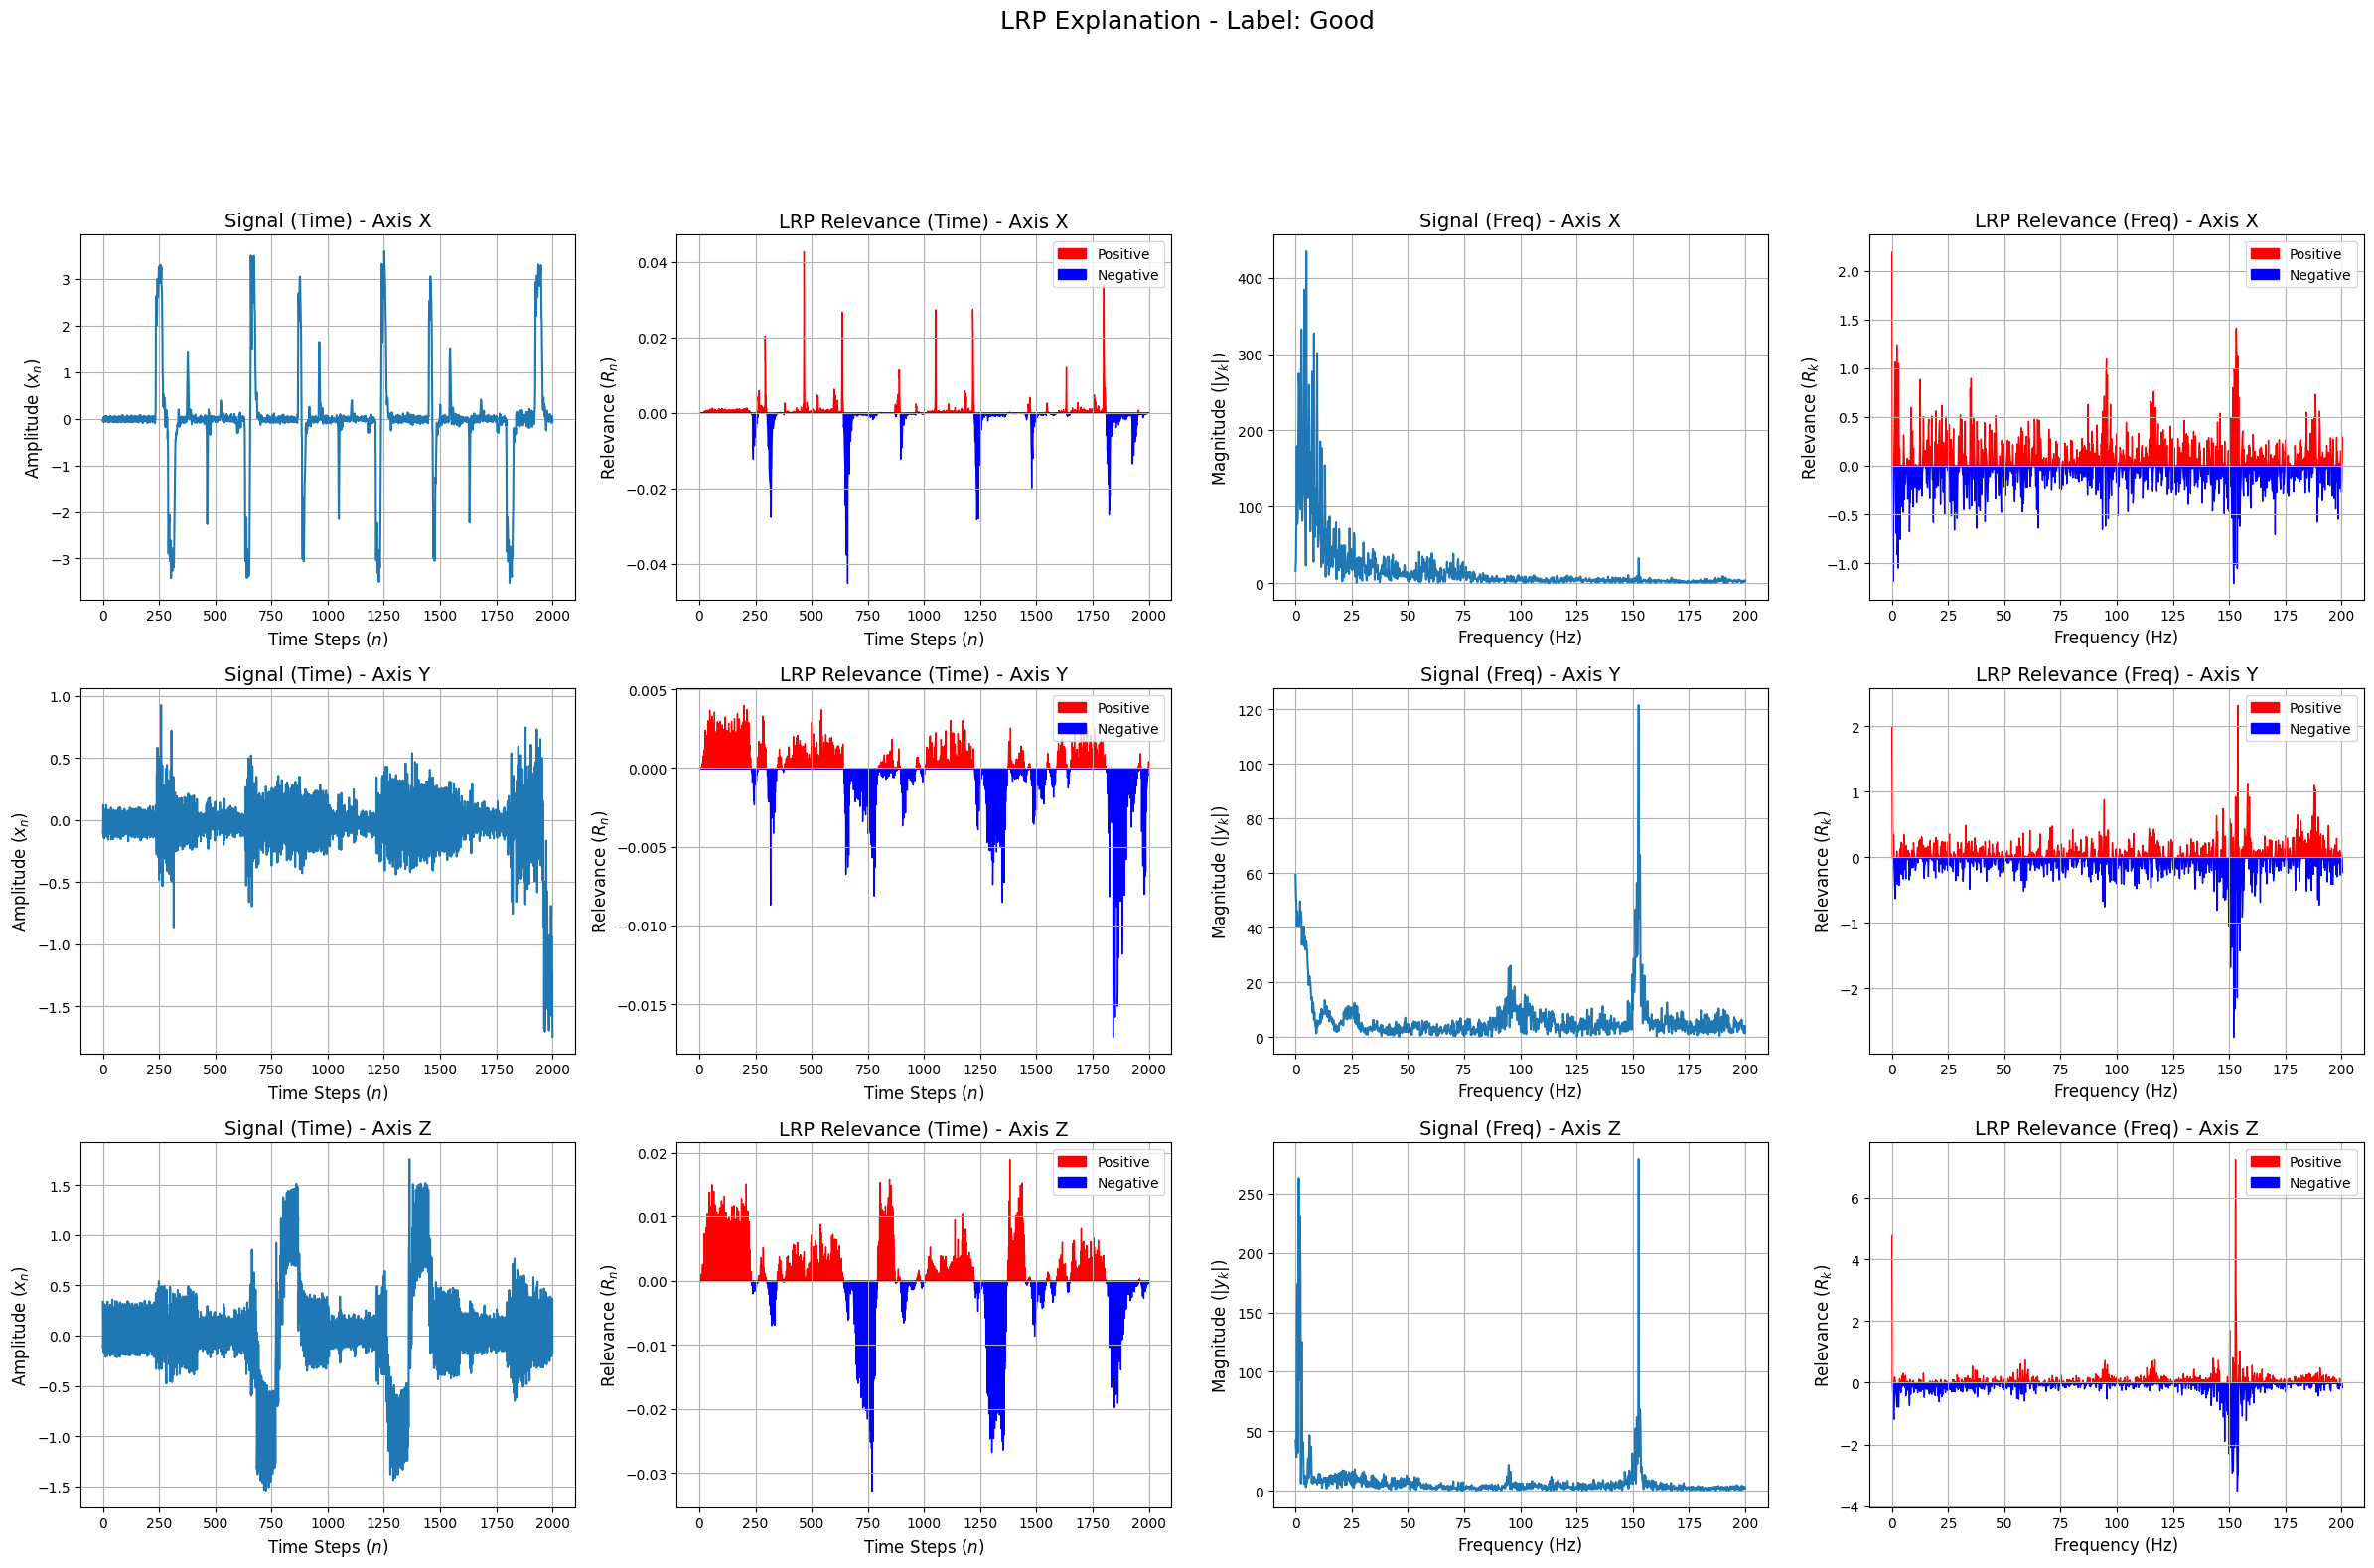

In [91]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

#### FFT-LRP implementation

In [52]:
relevance_time, relevance_freq, signal_freq, relevance_timefreq, signal_timefreq, input_signal, freqs, predicted_label = compute_fft_lrp_relevance(
        model=model,
        sample=sample,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=64,  # Increased to reduce memory usage
        window_width=128,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[-2.1991, -0.5427, -0.7575,  ..., -0.0159, -0.2375, -0.3022]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000,  0.4252,  0.9671,  ...,  0.5597, -0.1105, -0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

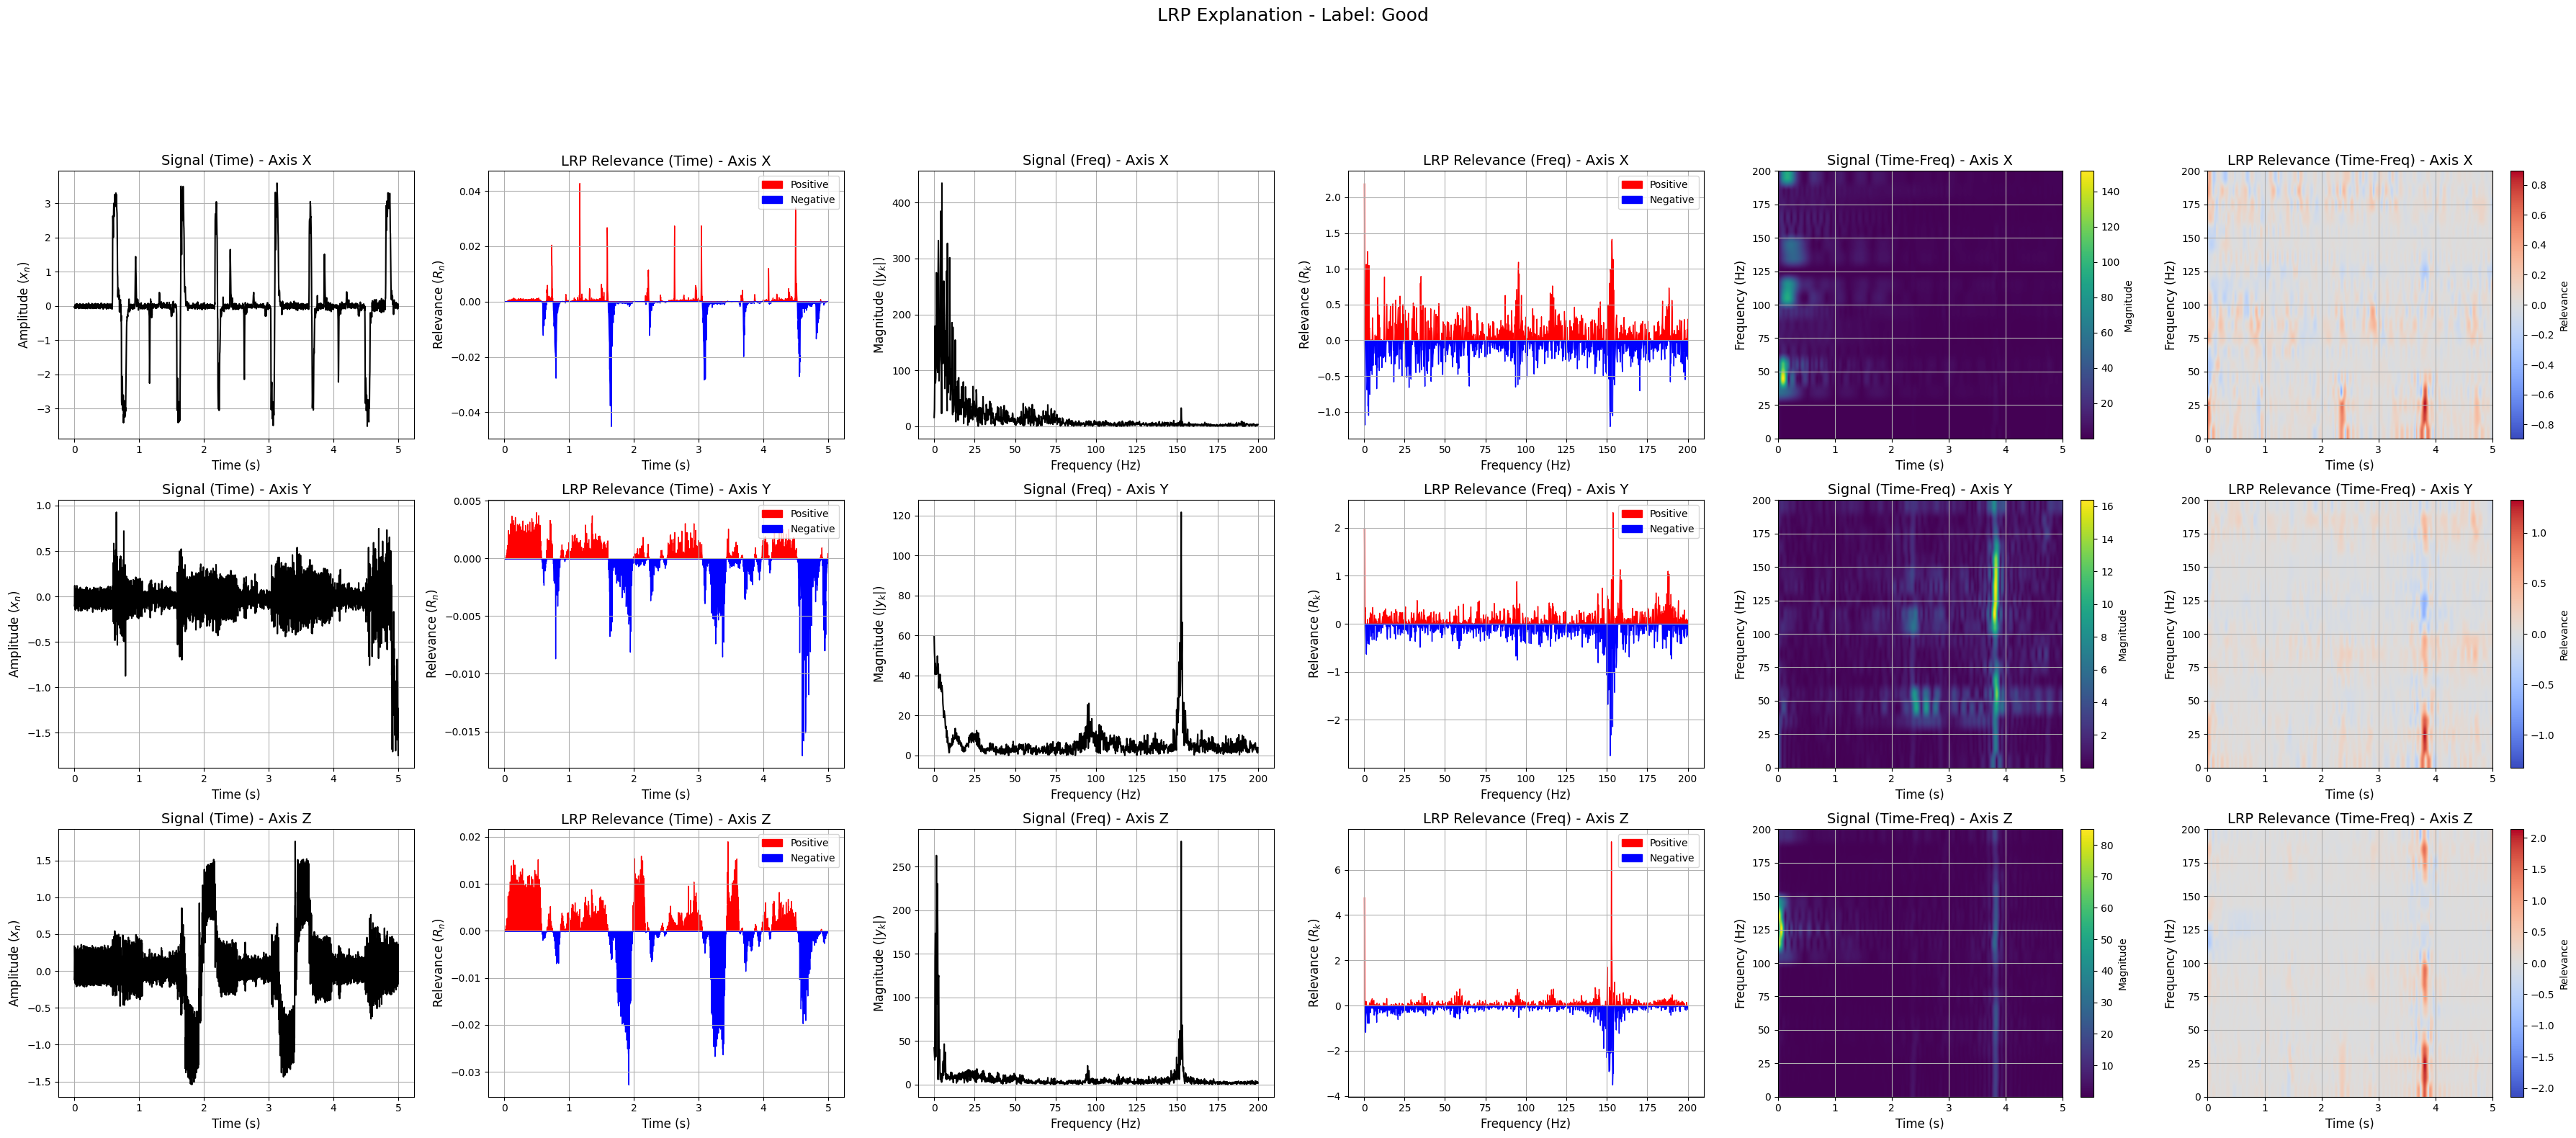

In [53]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time,
    relevance_freq=relevance_freq,
    signal_freq=signal_freq,
    relevance_timefreq=relevance_timefreq,
    signal_timefreq=signal_timefreq,
    input_signal=input_signal,
    freqs=freqs,
    predicted_label=predicted_label,
    signal_length=2000,
    sampling_rate=400,
    k_max=200
)

In [55]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}")
print(label_b, sample_b, label_b.shape, sample_b.shape)


Random Index: 0, Predicted_label:1
tensor(1, device='cuda:0') tensor([[ 1.7179,  1.9670,  2.7029,  ...,  0.9368,  0.8582,  0.3458],
        [-0.2081, -0.1590, -0.9186,  ..., -0.5072,  0.3208, -0.3993],
        [ 0.5549, -0.8597,  0.1598,  ...,  0.5599, -1.0429,  0.6663]],
       device='cuda:0') torch.Size([]) torch.Size([3, 2000])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 28 Label: Good


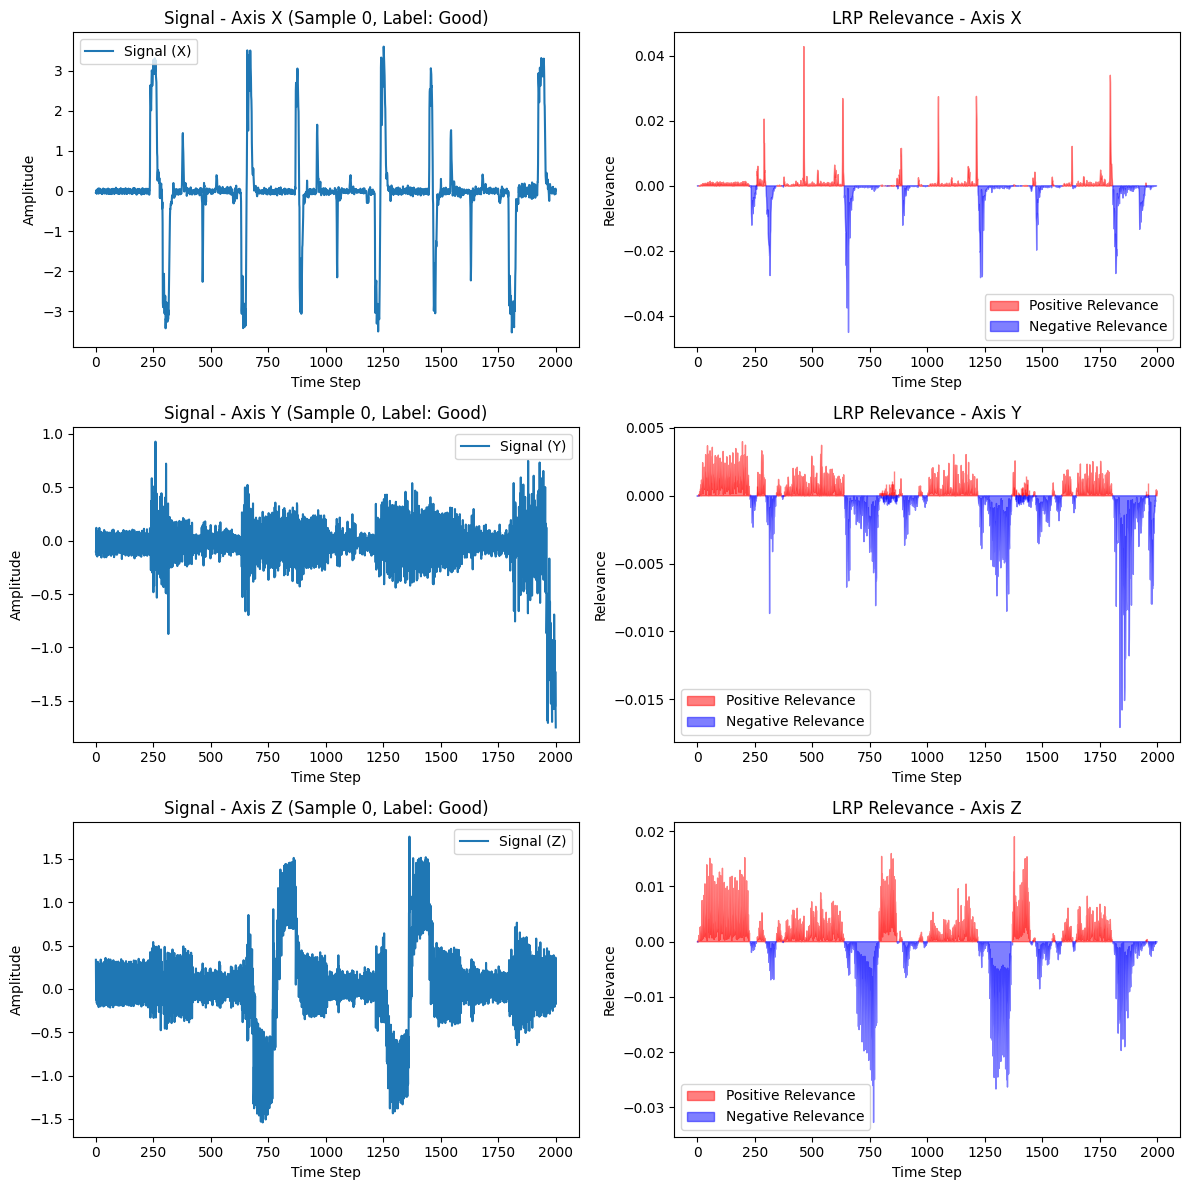

In [56]:
relevance, input_signal, final_label = compute_lrp_relevance(
    model=model,
    sample=sample,  # Shape: (3, 10000) or torch tensor
    label=label,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal,
    relevance=relevance,
    label=final_label)

Min relevance: -0.045074474066495895, Max relevance: 0.042838141322135925
 Maximum Absolute Attribution in Axis 0: 0.045074474066495895
 Maximum Absolute Attribution in Axis 1: 0.0170736126601696
 Maximum Absolute Attribution in Axis 2: 0.03271910920739174


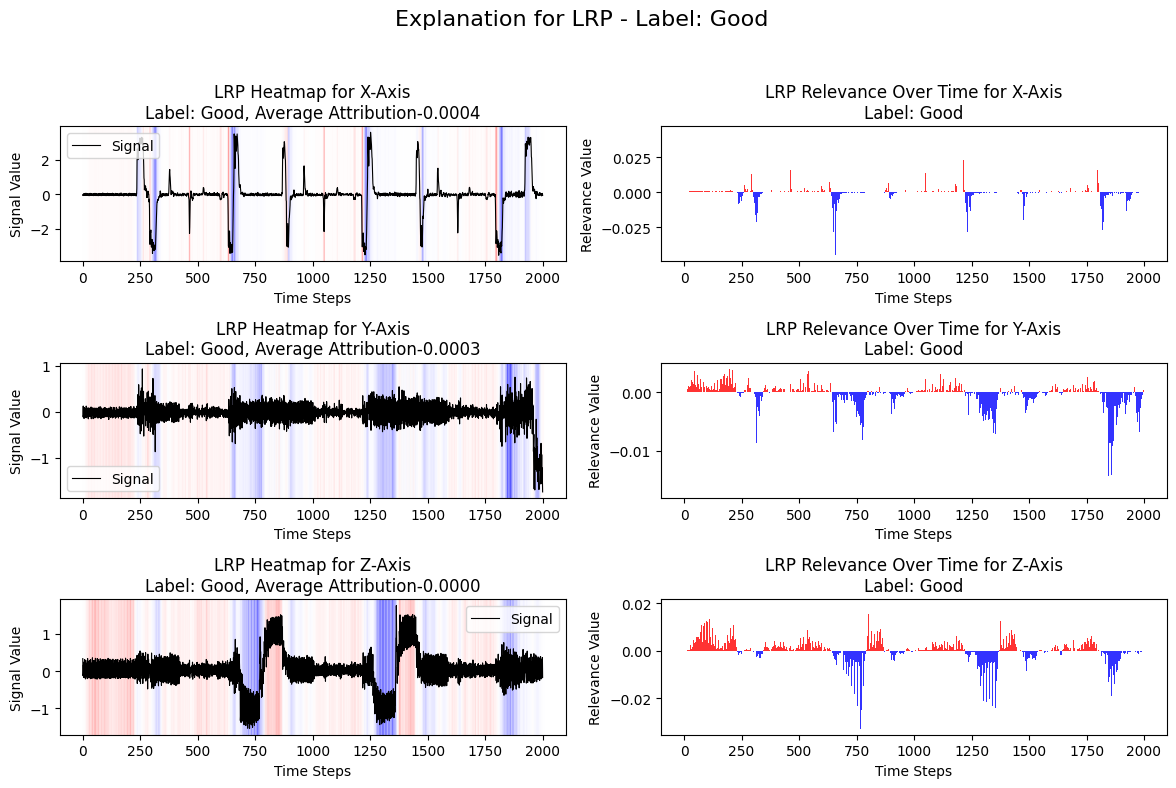

In [57]:

print(f"Min relevance: {np.min(relevance)}, Max relevance: {np.max(relevance)}")
visualize_with_label_attribution(sample, relevance, label, "LRP")


Min relevance: -0.07722852379083633, Max relevance: 0.05215015634894371
 Maximum Absolute Attribution in Axis 0: 0.07722852379083633
 Maximum Absolute Attribution in Axis 1: 0.02807440608739853
 Maximum Absolute Attribution in Axis 2: 0.02334407903254032


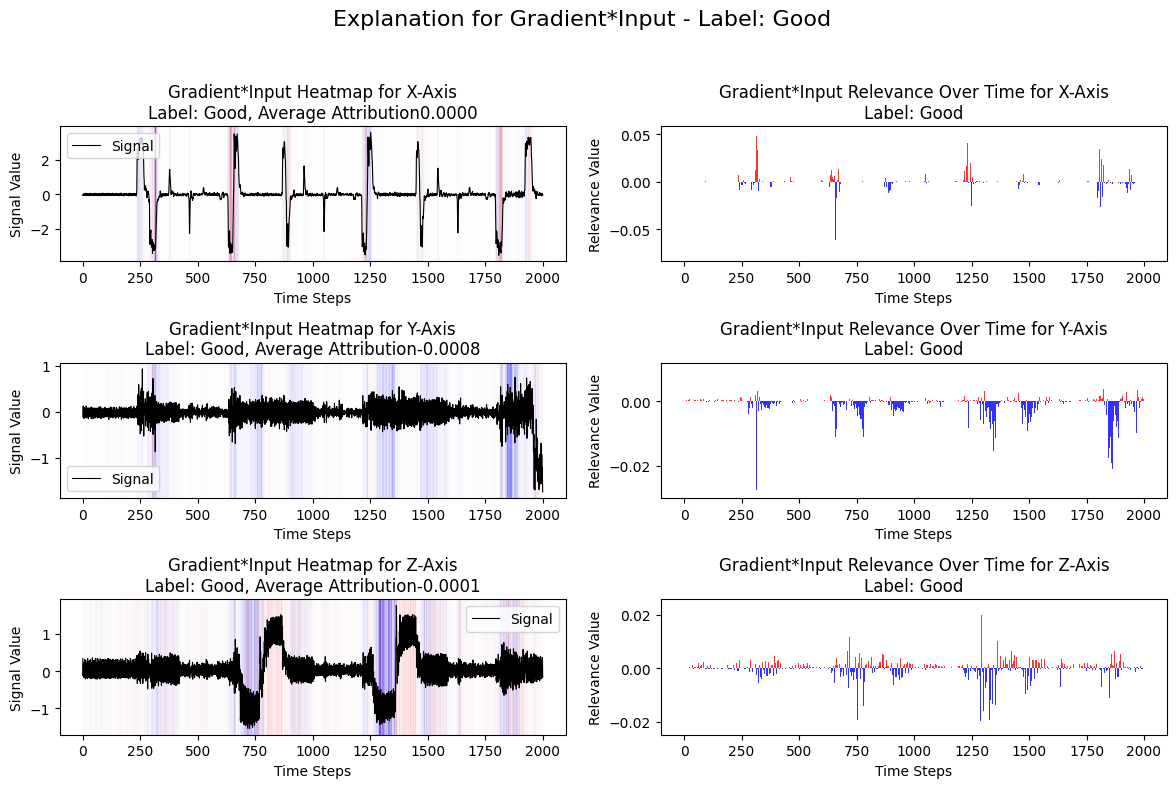

In [58]:

# Grad*Input
grad_input_attr, _ = grad_times_input_relevance(model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [59]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1093                  1.691319   
1  Axis 1             818                  0.334945   
2  Axis 2            1040                  1.618552   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001547             907                 -1.638657   
1                    0.000409            1182                 -1.996090   
2                    0.001556             960                 -1.808688   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.001807                     0.052661   
1                   -0.001689                    -1.661145   
2                   -0.001884                    -0.190136   

   Average Relevance (Pos + Neg)  
0                       0.000026  
1                      -0.000831  
2                      -0.000095  


Min relevance: -0.0031117573380470276, Max relevance: 0.0012643751688301563
 Maximum Absolute Attribution in Axis 0: 0.0031117573380470276
 Maximum Absolute Attribution in Axis 1: 0.0018754443153738976
 Maximum Absolute Attribution in Axis 2: 0.0021877356339246035


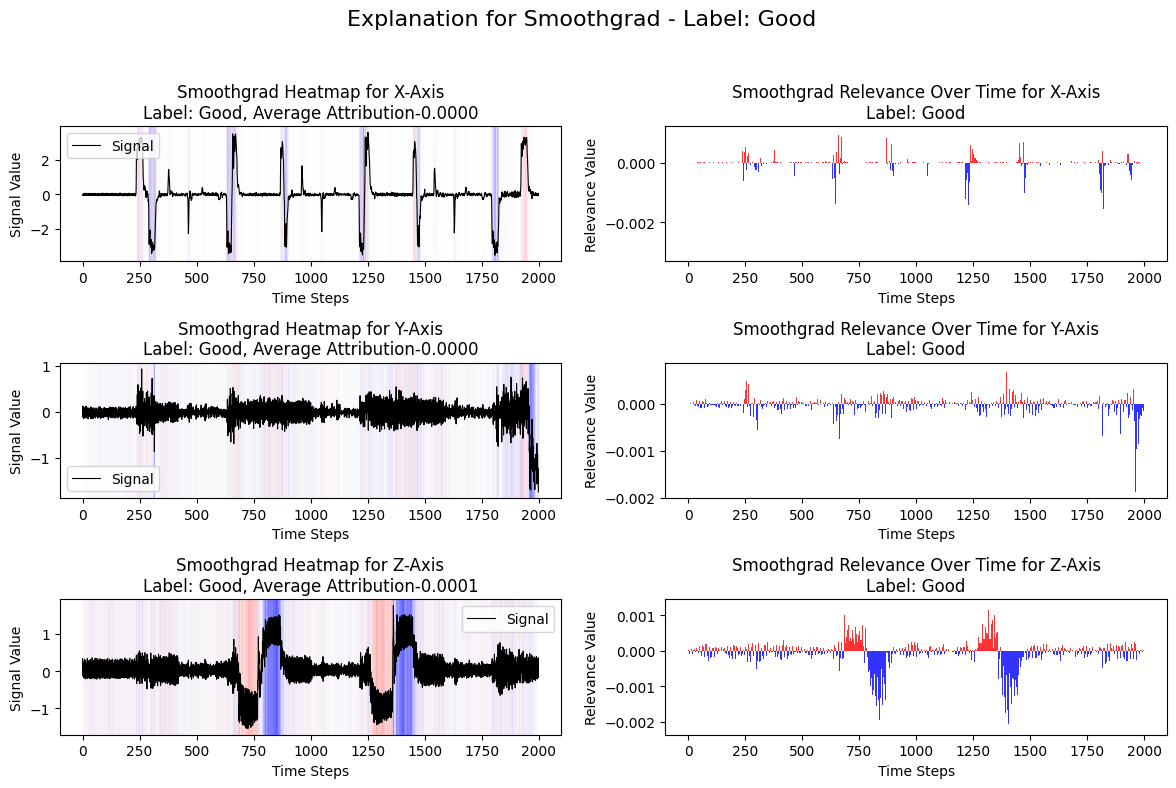

In [60]:

# SmoothGrad
smoothgrad_attr, _ = smoothgrad_relevance(model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.01139974594116211, Max relevance: 0.03322601318359375
 Maximum Absolute Attribution in Axis 0: 0.03322601318359375
 Maximum Absolute Attribution in Axis 1: 0.01139974594116211
 Maximum Absolute Attribution in Axis 2: 0.006590366363525391


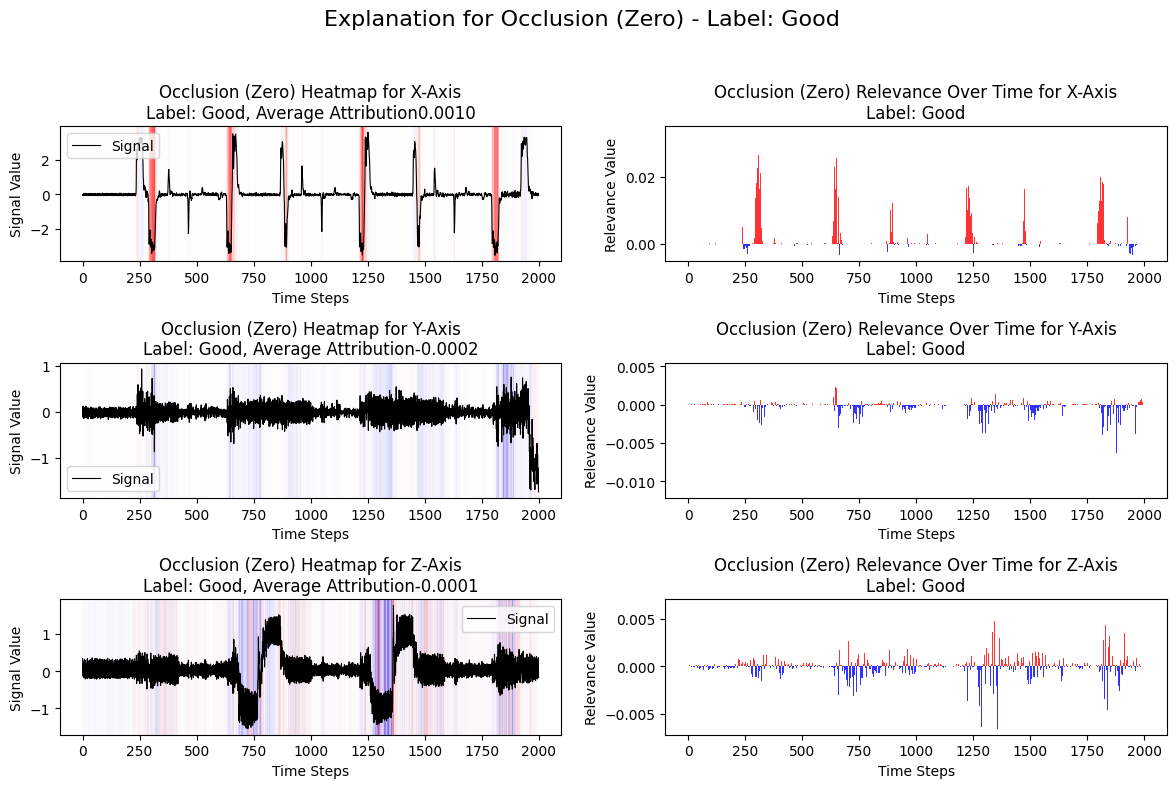

In [61]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = occlusion_signal_relevance(model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.06829166412353516, Max relevance: 0.041344642639160156
 Maximum Absolute Attribution in Axis 0: 0.06829166412353516
 Maximum Absolute Attribution in Axis 1: 0.06829166412353516
 Maximum Absolute Attribution in Axis 2: 0.06829166412353516


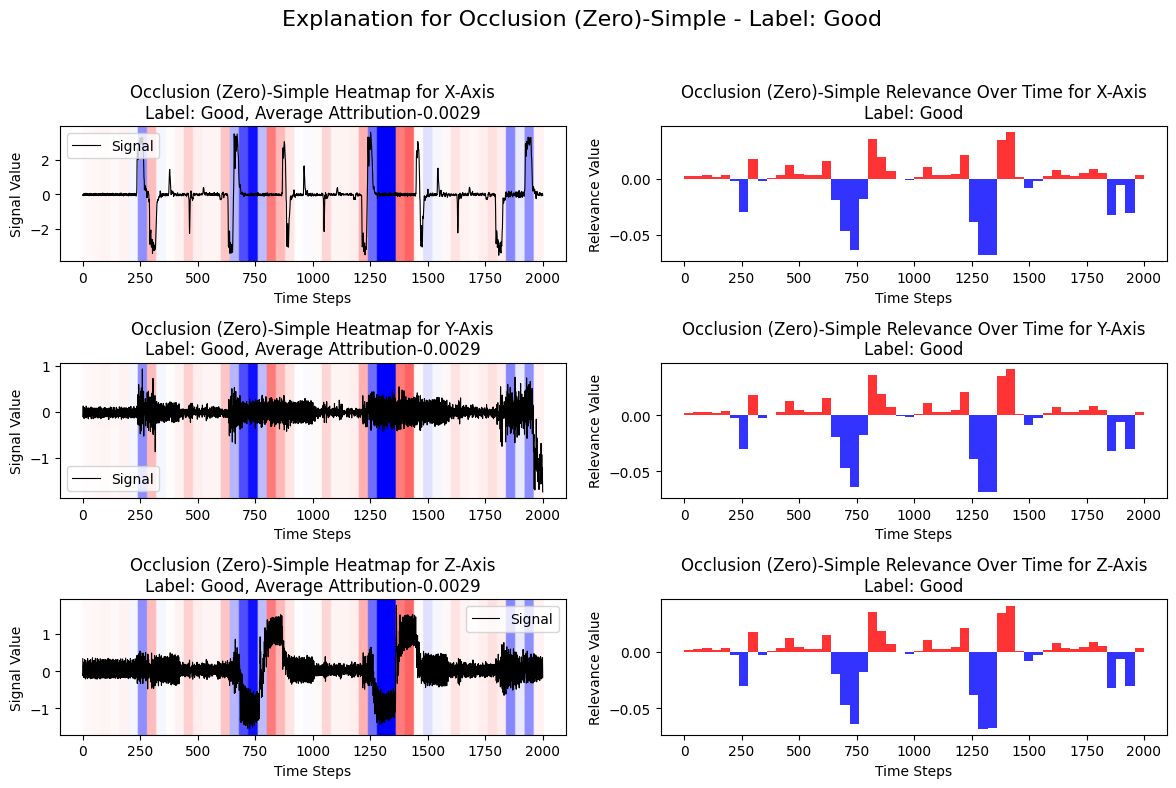

In [62]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -0.0941915512084961, Max relevance: 0.15671777725219727
 Maximum Absolute Attribution in Axis 0: 0.15671777725219727
 Maximum Absolute Attribution in Axis 1: 0.15671777725219727
 Maximum Absolute Attribution in Axis 2: 0.15671777725219727


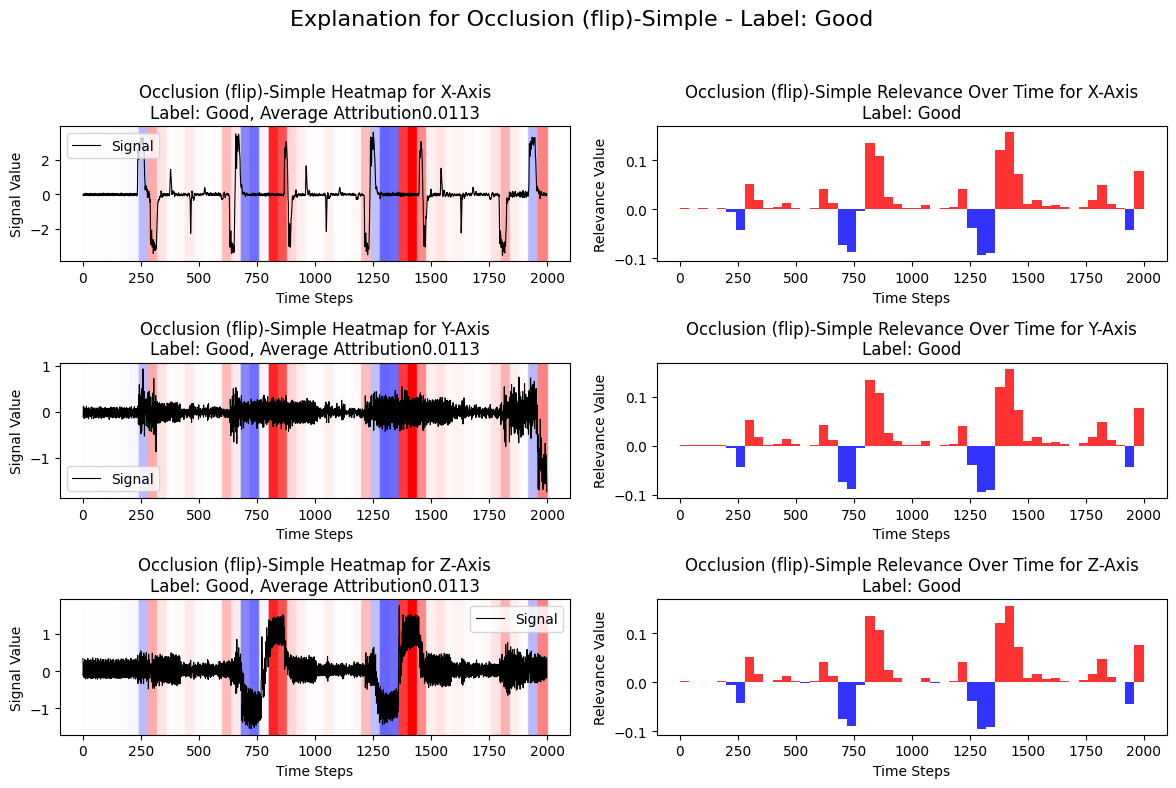

In [63]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.014270305633544922, Max relevance: 0.047943115234375
 Maximum Absolute Attribution in Axis 0: 0.047943115234375
 Maximum Absolute Attribution in Axis 1: 0.023917675018310547
 Maximum Absolute Attribution in Axis 2: 0.014270305633544922


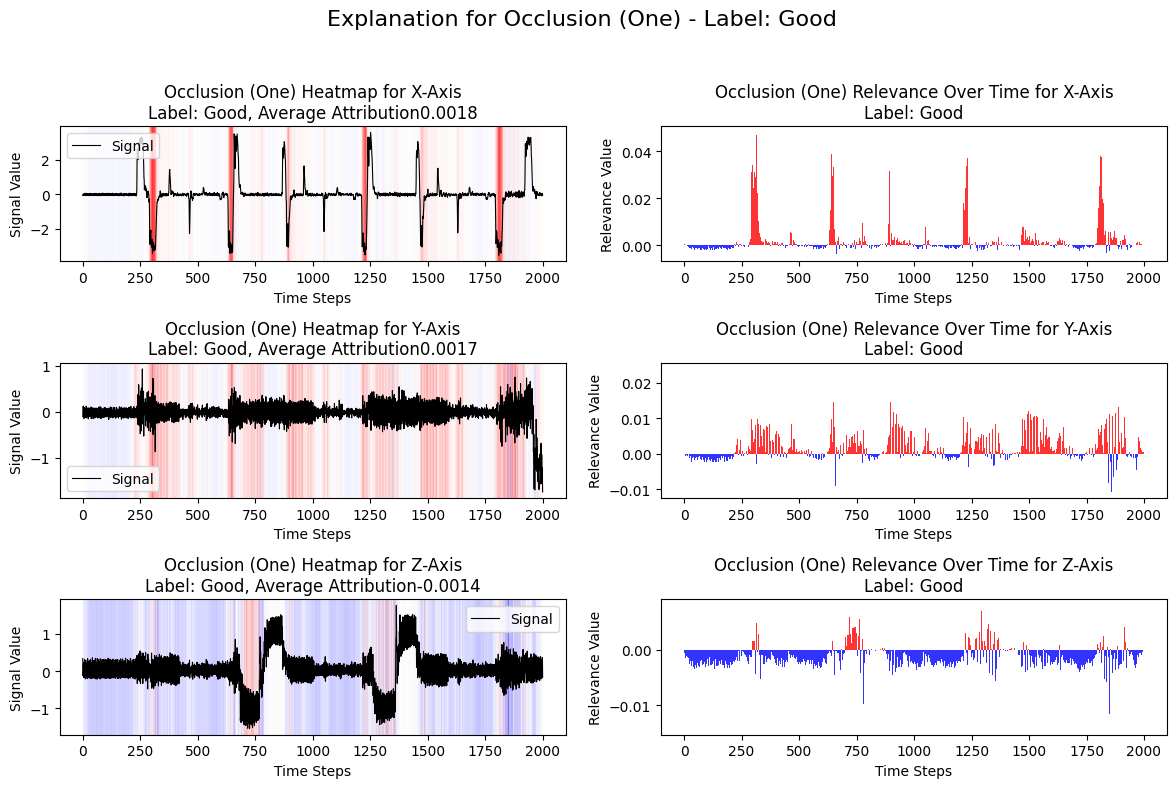

In [64]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = occlusion_signal_relevance(model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.02130413055419922, Max relevance: 0.02045583724975586
 Maximum Absolute Attribution in Axis 0: 0.02045583724975586
 Maximum Absolute Attribution in Axis 1: 0.02130413055419922
 Maximum Absolute Attribution in Axis 2: 0.015329837799072266


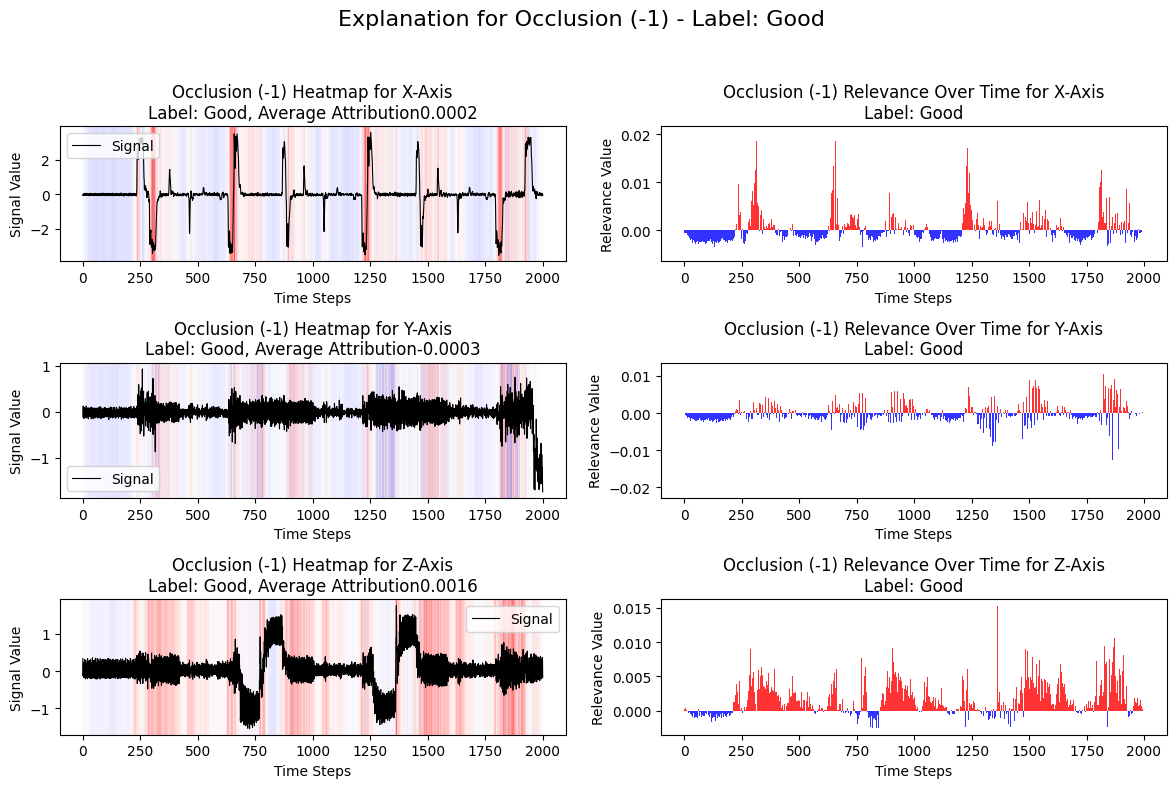

In [65]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = occlusion_signal_relevance(model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.019384384155273438, Max relevance: 0.0837092399597168
 Maximum Absolute Attribution in Axis 0: 0.0837092399597168
 Maximum Absolute Attribution in Axis 1: 0.019384384155273438
 Maximum Absolute Attribution in Axis 2: 0.02630138397216797


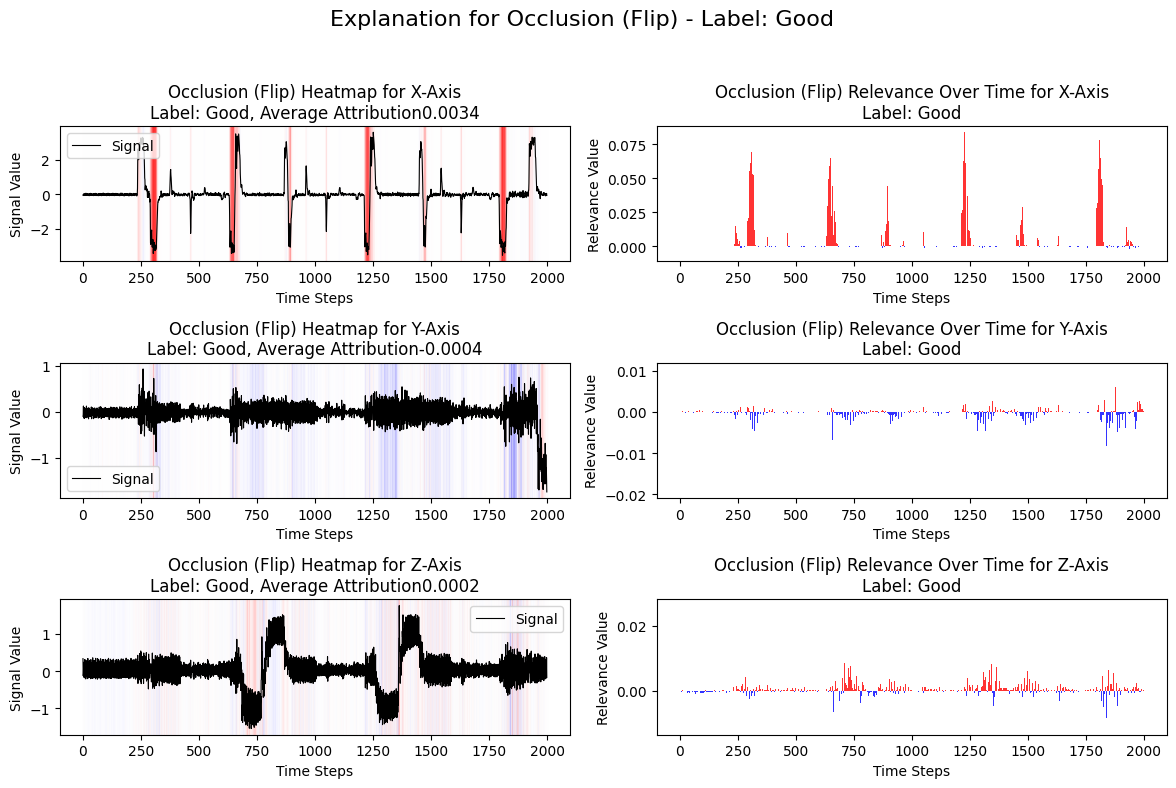

In [66]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = occlusion_signal_relevance(model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


Min relevance: -0.02008041739463806, Max relevance: 0.014620167203247547
 Maximum Absolute Attribution in Axis 0: 0.014620167203247547
 Maximum Absolute Attribution in Axis 1: 0.014535280875861645
 Maximum Absolute Attribution in Axis 2: 0.02008041739463806


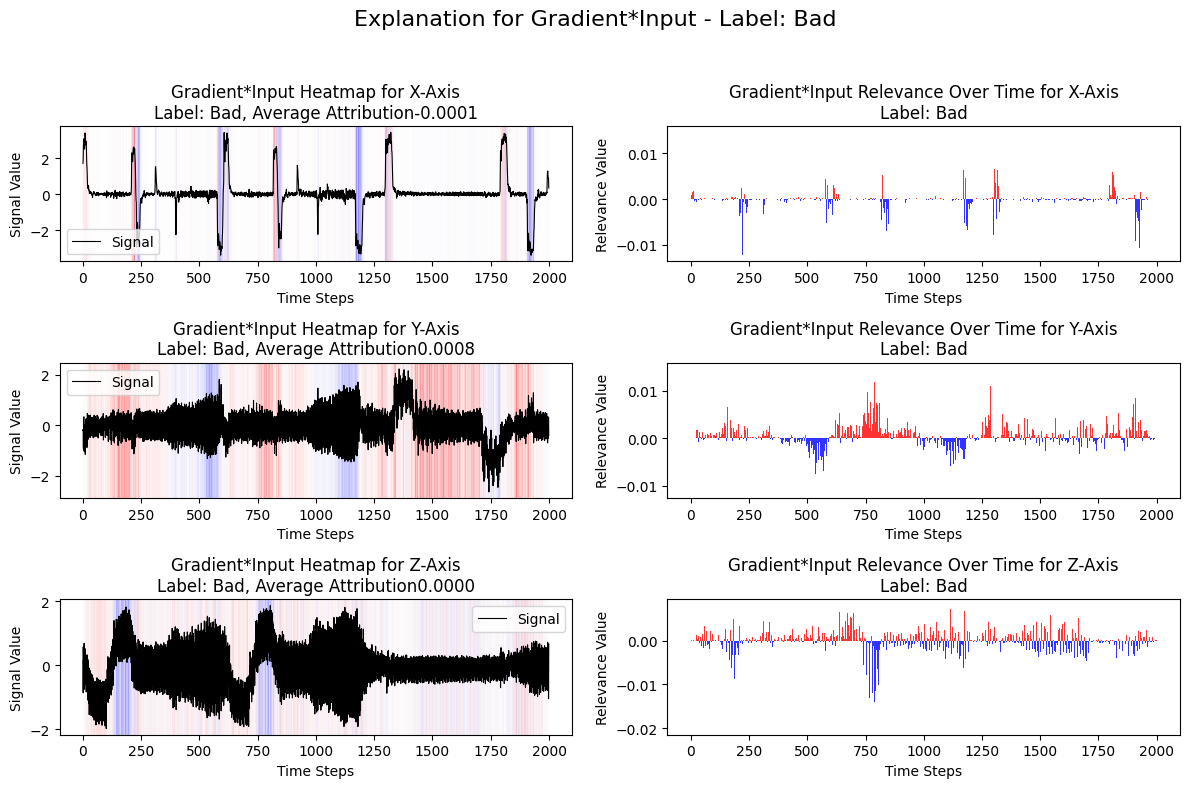

In [67]:
# Grad*Input
grad_input_attr_b, _ = grad_times_input_relevance(model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [86]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1021                  0.390496   
1  Axis 1            1256                  2.377195   
2  Axis 2            1025                  1.478566   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000382             979                 -0.630194   
1                    0.001893             744                 -0.828726   
2                    0.001443             975                 -1.468577   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000644                    -0.239698   
1                   -0.001114                     1.548469   
2                   -0.001506                     0.009989   

   Average Relevance (Pos + Neg)  
0                      -0.000120  
1                       0.000774  
2                       0.000005  


Min relevance: -0.0018538201693445444, Max relevance: 0.0013698524562641978
 Maximum Absolute Attribution in Axis 0: 0.001034275977872312
 Maximum Absolute Attribution in Axis 1: 0.0015893956879153848
 Maximum Absolute Attribution in Axis 2: 0.0018538201693445444


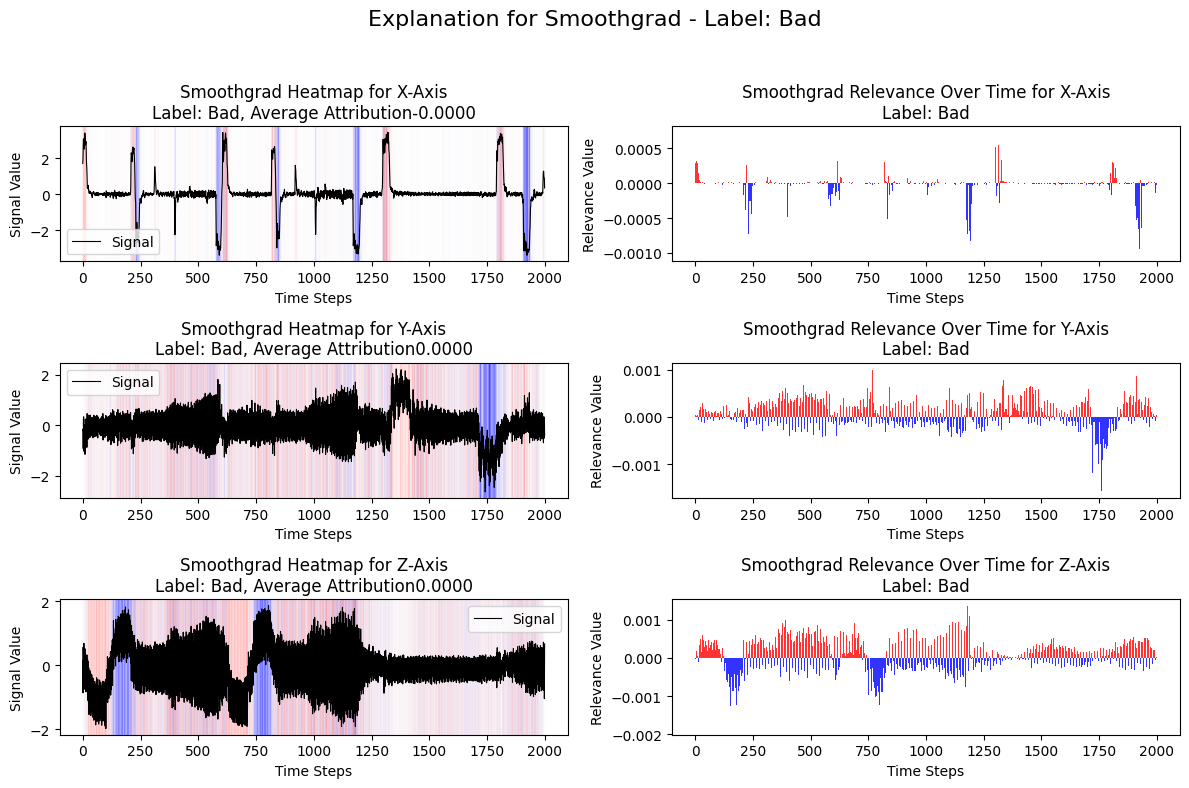

In [69]:
# SmoothGrad
smoothgrad_attr_b, _ = smoothgrad_relevance(model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [85]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             992                  0.031875   
1  Axis 1            1029                  0.245417   
2  Axis 2            1004                  0.322402   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000032            1008                 -0.060573   
1                    0.000239             971                 -0.179629   
2                    0.000321             996                 -0.276938   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000060                    -0.028698   
1                   -0.000185                     0.065788   
2                   -0.000278                     0.045464   

   Average Relevance (Pos + Neg)  
0                      -0.000014  
1                       0.000033  
2                       0.000023  


Min relevance: -0.0059356689453125, Max relevance: 0.005752086639404297
 Maximum Absolute Attribution in Axis 0: 0.0059356689453125
 Maximum Absolute Attribution in Axis 1: 0.005752086639404297
 Maximum Absolute Attribution in Axis 2: 0.0035507678985595703


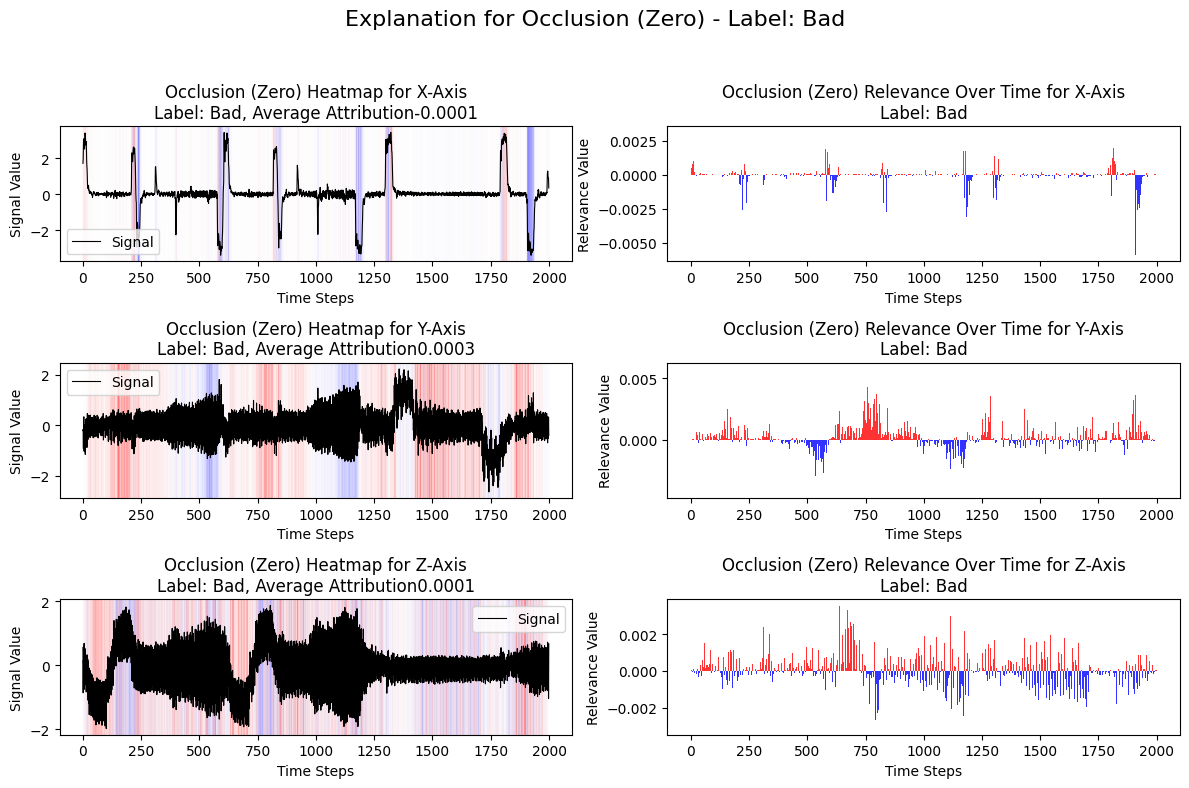

In [71]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.007142066955566406, Max relevance: 0.009038448333740234
 Maximum Absolute Attribution in Axis 0: 0.007142066955566406
 Maximum Absolute Attribution in Axis 1: 0.009026527404785156
 Maximum Absolute Attribution in Axis 2: 0.009038448333740234


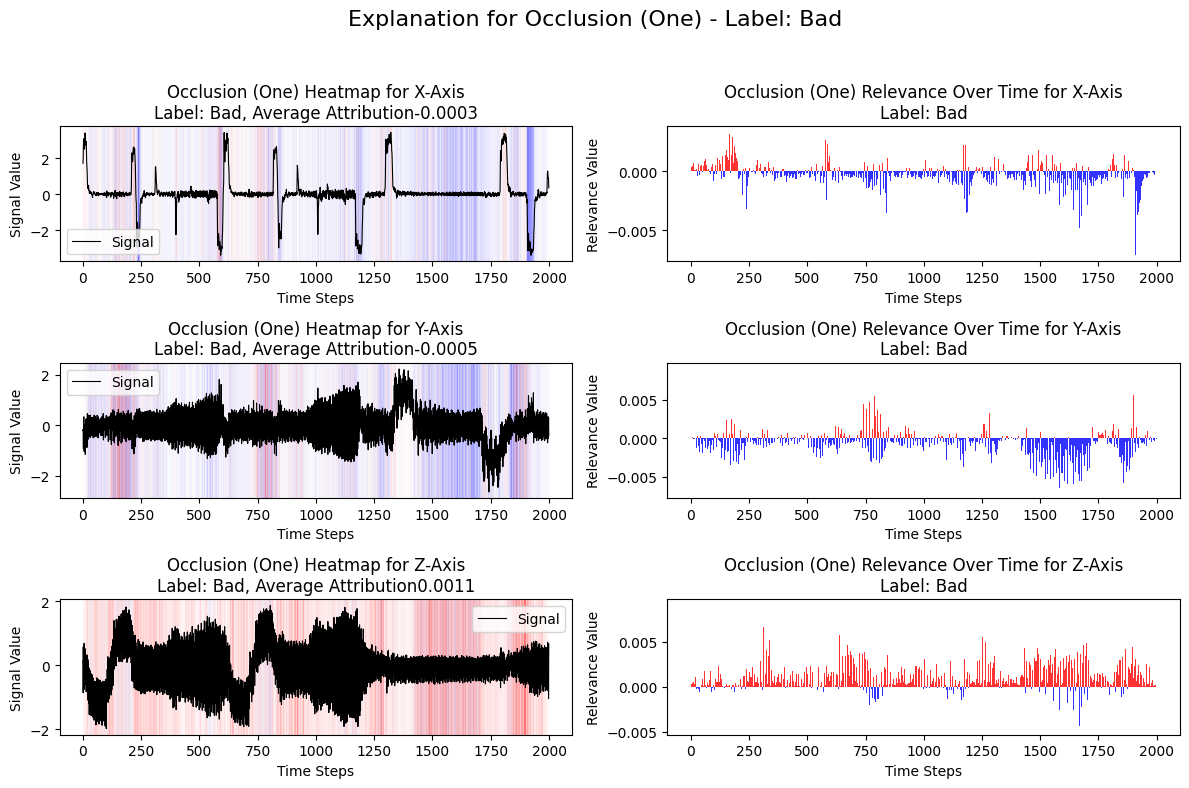

In [72]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.009937286376953125, Max relevance: 0.011161327362060547
 Maximum Absolute Attribution in Axis 0: 0.004467487335205078
 Maximum Absolute Attribution in Axis 1: 0.011161327362060547
 Maximum Absolute Attribution in Axis 2: 0.009937286376953125


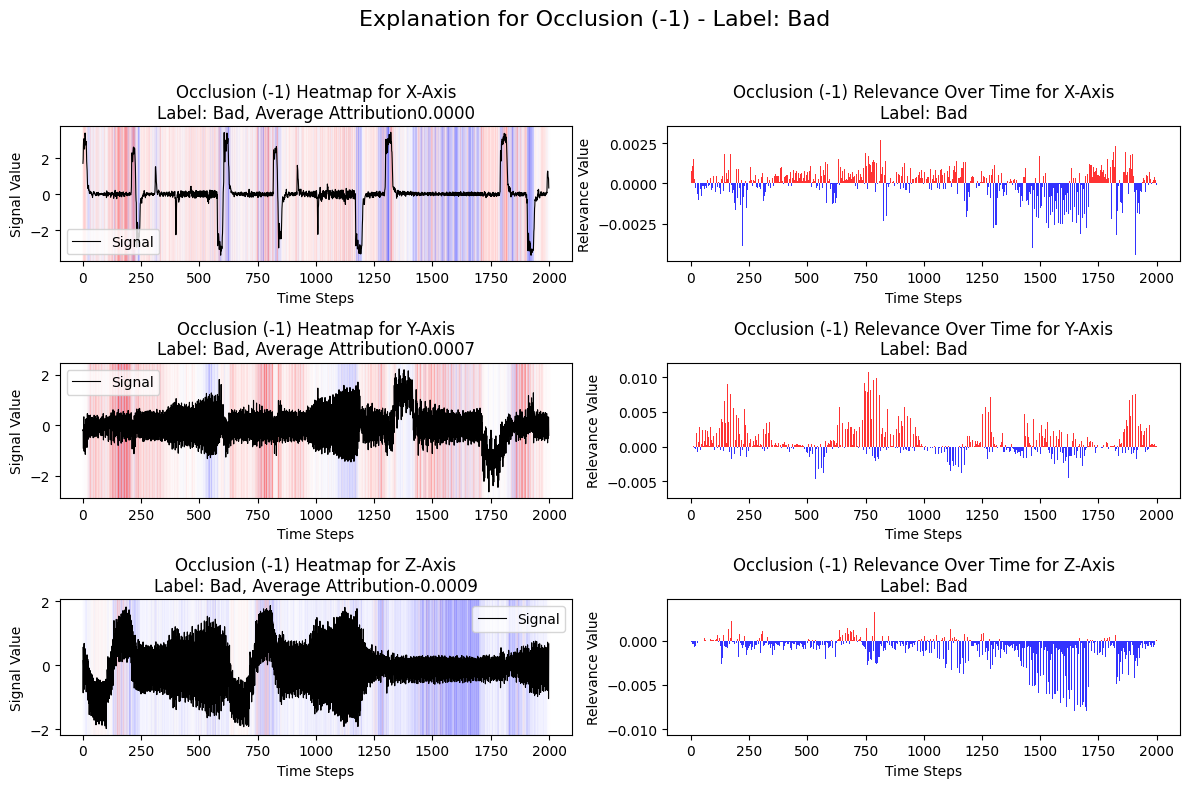

In [73]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.009331226348876953, Max relevance: 0.009818553924560547
 Maximum Absolute Attribution in Axis 0: 0.009331226348876953
 Maximum Absolute Attribution in Axis 1: 0.009818553924560547
 Maximum Absolute Attribution in Axis 2: 0.007534980773925781


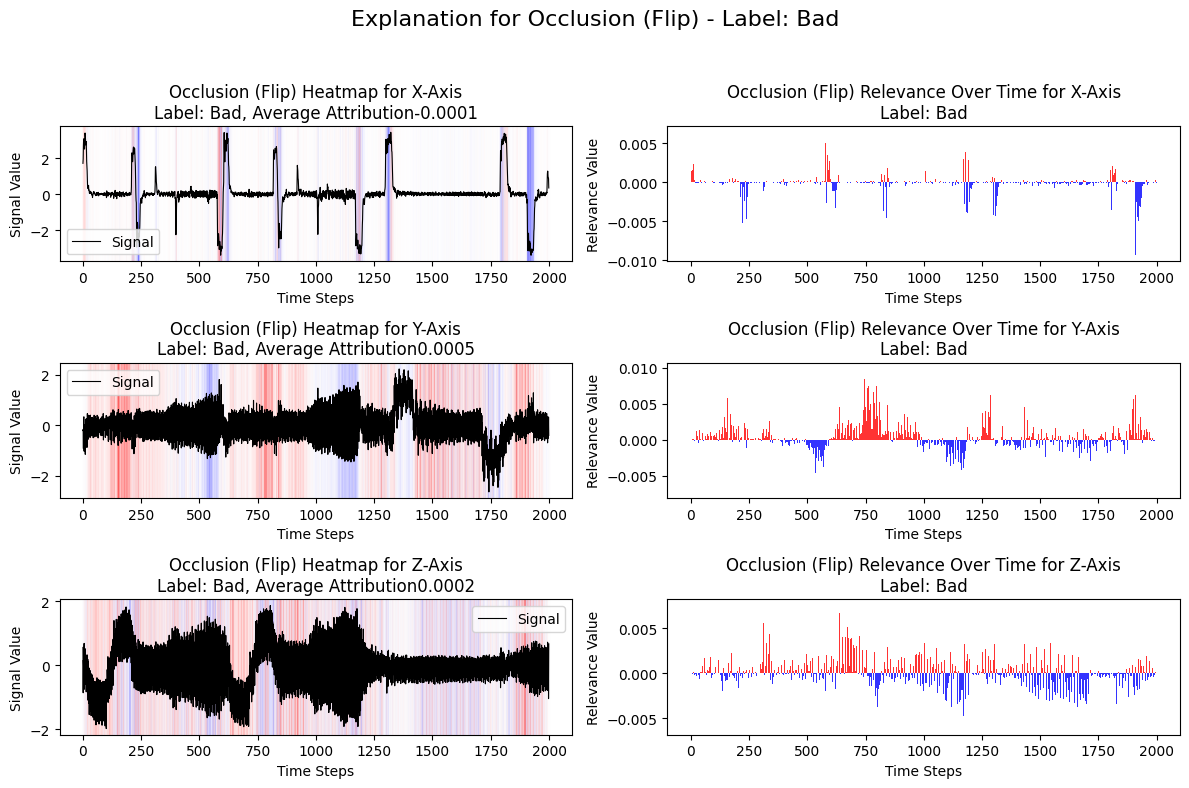

In [74]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


In [75]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1001                  0.241272   
1  Axis 1            1196                  1.658643   
2  Axis 2            1020                  1.221026   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000241             991                 -0.492242   
1                    0.001387             801                 -0.678387   
2                    0.001197             979                 -0.865807   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000497                    -0.250970   
1                   -0.000847                     0.980256   
2                   -0.000884                     0.355219   

   Average Relevance (Pos + Neg)  
0                      -0.000126  
1                       0.000491  
2                       0.000178  


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 0 Label: Bad


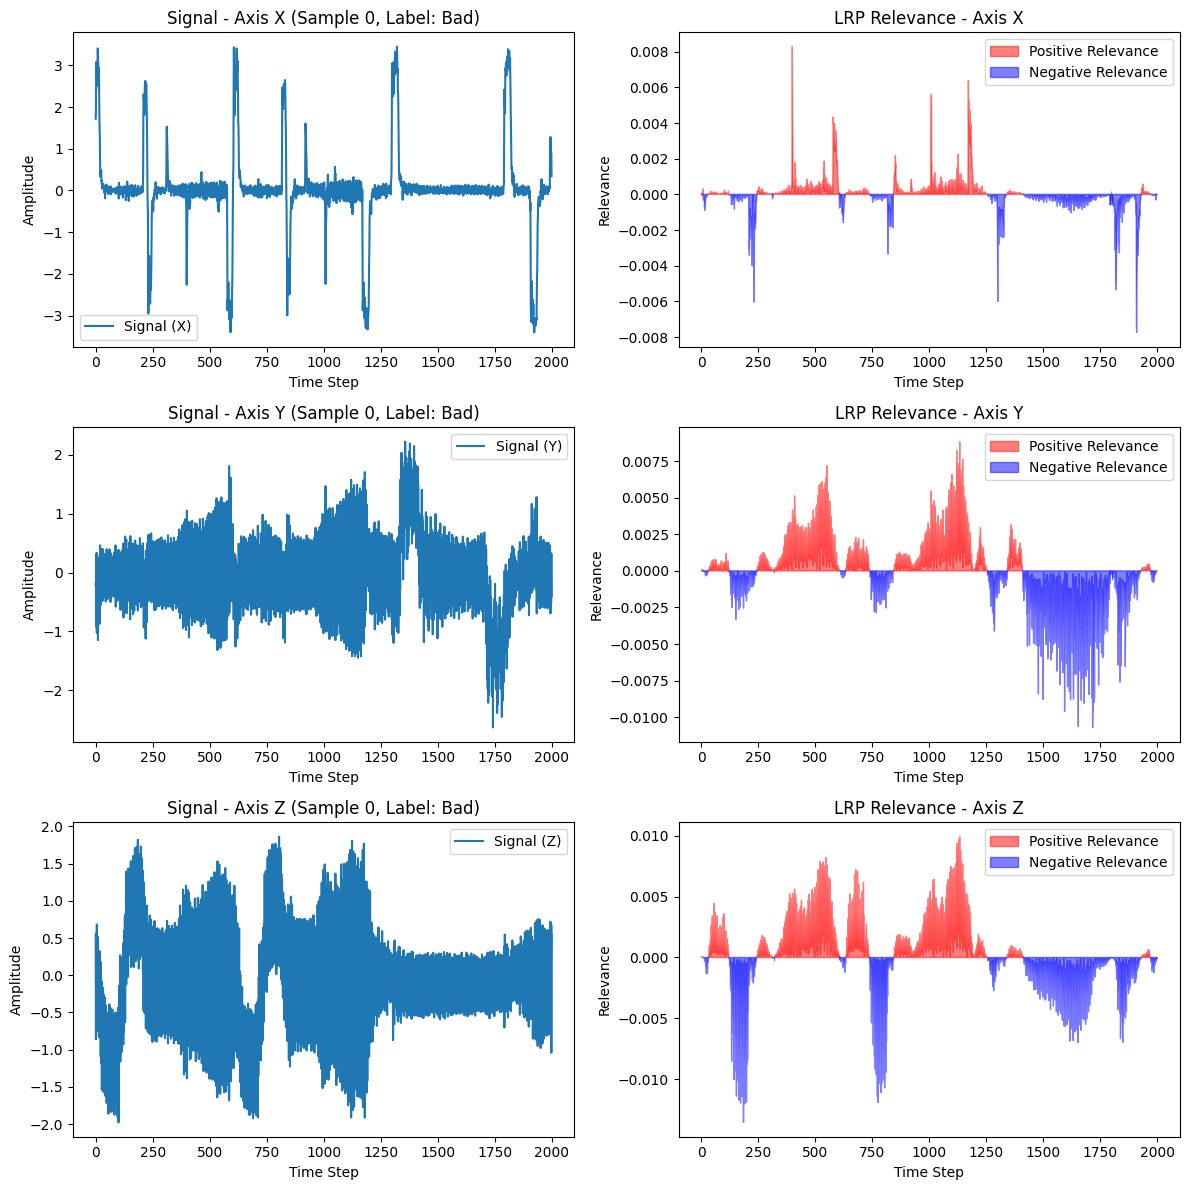

In [76]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index_b} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.013538450933992863, Max relevance: 0.009921852499246597
 Maximum Absolute Attribution in Axis 0: 0.008289971388876438
 Maximum Absolute Attribution in Axis 1: 0.01070327963680029
 Maximum Absolute Attribution in Axis 2: 0.013538450933992863


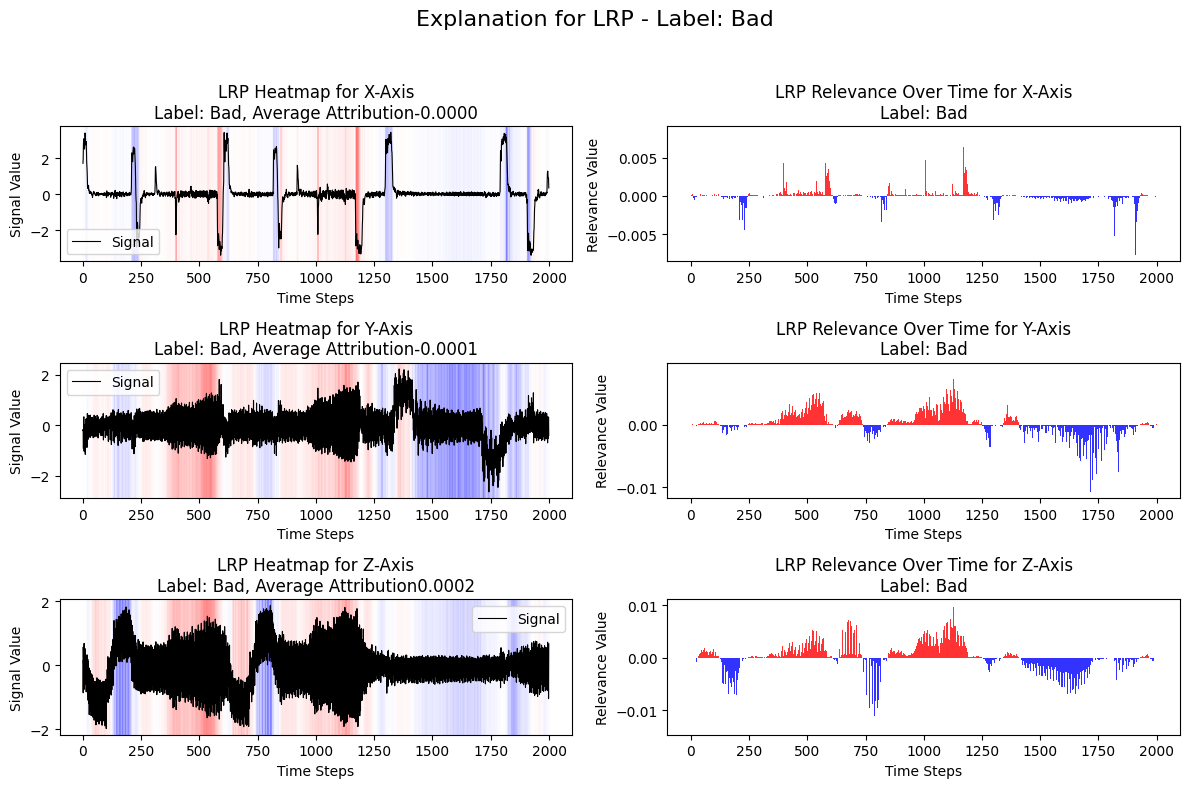

In [77]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [78]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_dft_lrp_relevance(
        model=model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
3
1001


E:\Thesis\Datasets\CNC\dft_lrp.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


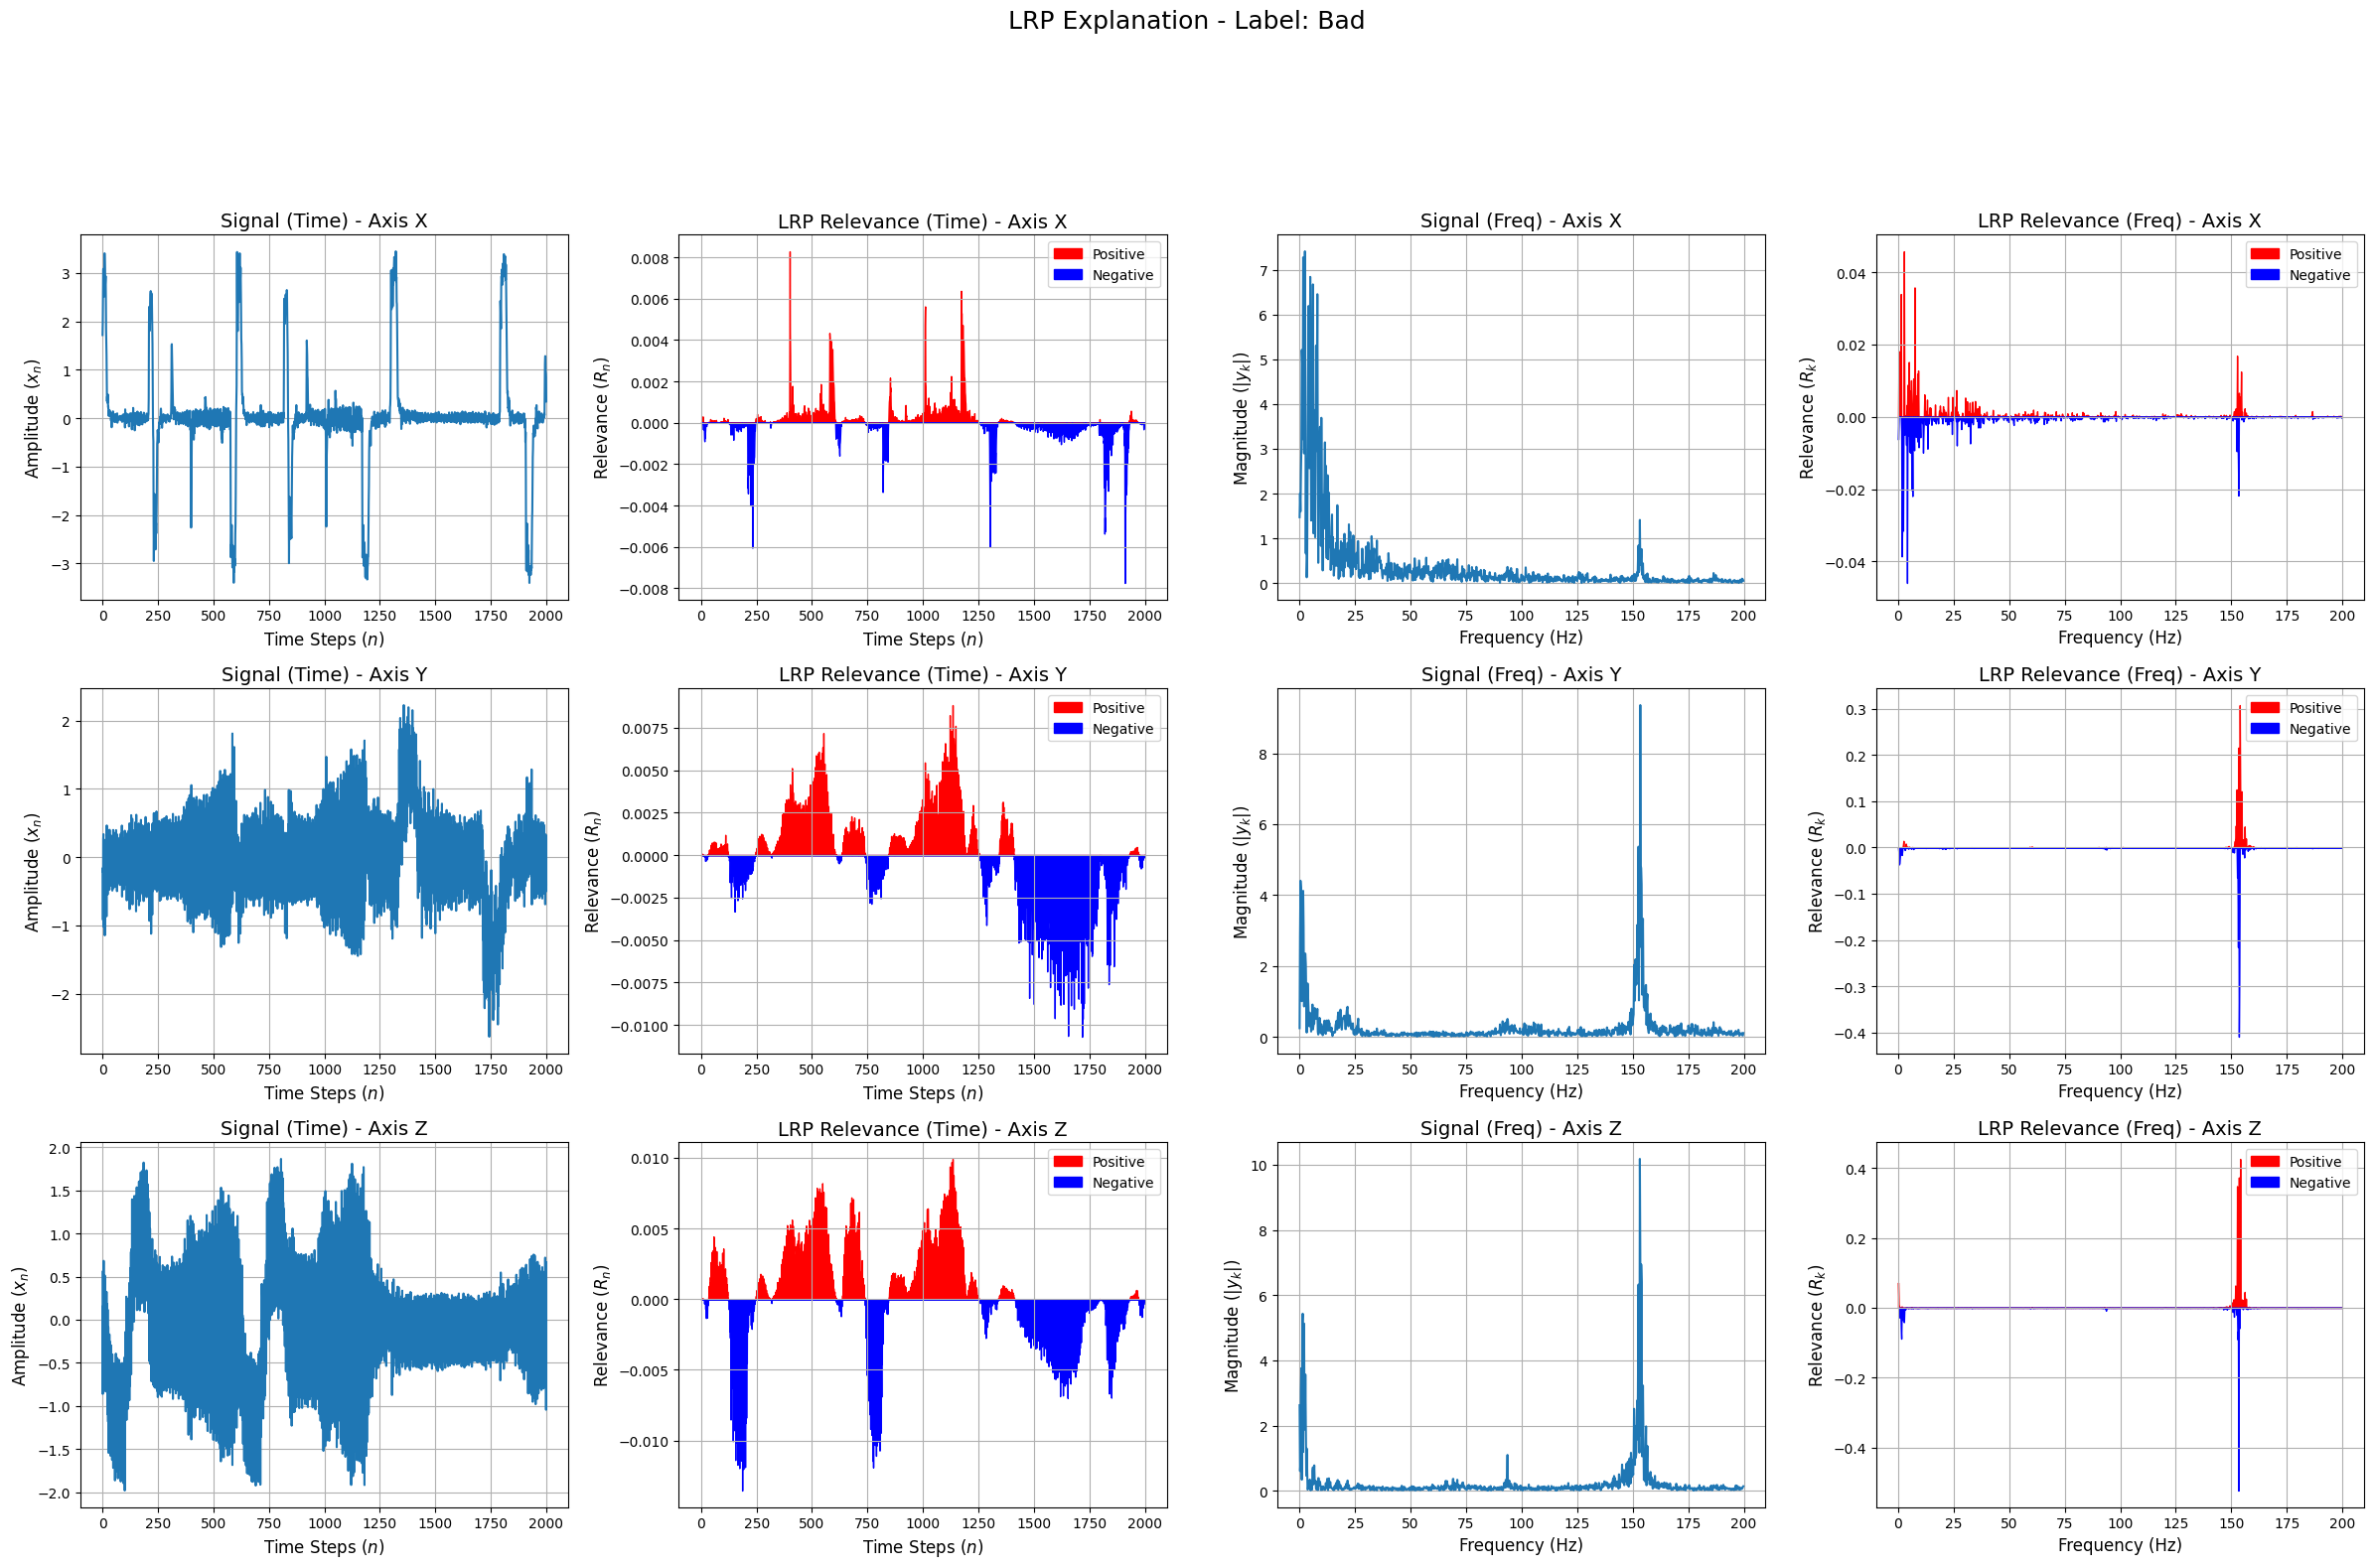

In [79]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [82]:
summary_b_lrp = summarize_attributions( relevance_freq_b)  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_lrp = []
for axis, values in summary_b_lrp.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp.append(row)

# Create the DataFrame
df_summary_lrp = pd.DataFrame(data_lrp)

# Display the DataFrame as a table
print(df_summary_lrp)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             477                  0.558808   
1  Axis 1             448                  1.331979   
2  Axis 2             484                  1.684990   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001172             524                 -0.592399   
1                    0.002973             553                 -1.475868   
2                    0.003481             517                 -1.297643   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.001131                    -0.033591   
1                   -0.002669                    -0.143888   
2                   -0.002510                     0.387346   

   Average Relevance (Pos + Neg)  
0                      -0.000034  
1                      -0.000144  
2                       0.000387  
